In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io.ascii import read
import fitsio

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
rmpath = os.path.join(os.sep, 'global', 'work', 'projects', 'redmapper')
rmcatfile = os.path.join(rmpath, 'redmapper_isedfit_v5.10_centrals.fits.gz')
# Set a path... just doing this on the fly for now.
kravsources = 'kravsources.txt'

In [4]:
rminfo = fitsio.FITS(rmcatfile)
rmcat = rminfo[1].read(columns=['Z', 'RA', 'DEC'])

In [27]:
sourceRA, sourceDEC, helioZ = np.loadtxt(kravsources, unpack=True, usecols=(1,2,3))
name = np.genfromtxt(kravsources, dtype='U', usecols=0)

In [28]:
from astropy.coordinates import SkyCoord
from astropy import units as u

In [35]:
rcoord = SkyCoord(ra=rmcat['RA']*u.degree, dec=rmcat['DEC']*u.degree)
kravcoord = SkyCoord(ra=sourceRA*u.degree, dec=sourceDEC*u.degree)
idx, sep2d, dist3d = kravcoord.match_to_catalog_sky(rcoord, nthneighbor=1)

In [30]:
print(len(idx))
print(idx)

9
[     0 239264 371354    232    548    623   3007 170802 387725]


In [31]:
gd = np.where(sep2d < 50 * u.arcsec)[0]
len(gd)

4

In [32]:
print(gd)
print(name[gd])

[0 3 4 5]
["'A2142'" "'A1795'" "'MKW3s'" "'A2052'"]


In [33]:
print(rmcat['RA'][idx[gd]])
print(rmcat['DEC'][idx[gd]])
print(rmcat['Z'][idx[gd]])

[ 239.58332907  207.22202106  230.46604816  229.18537268]
[ 27.23341292  26.60373126   7.70881574   7.02162407]
[ 0.09577668  0.06997315  0.06400454  0.05806554]


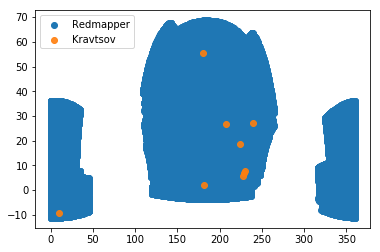

In [42]:
# All
fig, ax = plt.subplots()
ax.scatter(rmcat['RA'], rmcat['DEC'], label='Redmapper')
ax.scatter(sourceRA, sourceDEC, alpha=0.9, label='Kravtsov')
ax.legend(loc='upper left')

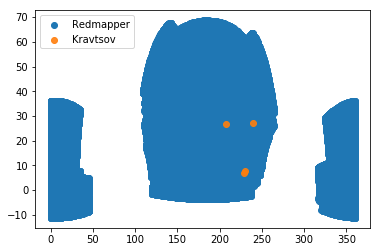

In [43]:
# Matches
fig, ax = plt.subplots()
ax.scatter(rmcat['RA'], rmcat['DEC'], label='Redmapper')
ax.scatter(sourceRA[gd], sourceDEC[gd], alpha=0.9, label='Kravtsov')
ax.legend(loc='upper left')